# Classifiers - low vs high complexity - no TFv1
Exploring different classifiers with different autoencoders. No contractive autoencoder because it needs TFv1 compatibility.

#### Table of contents:  

autoencoders:  
[Undercomplete Autoencoder](#Undercomplete-Autoencoder)  
[Sparse Autoencoder](#Sparse-Autoencoder)  
[Deep Autoencoder](#Deep-Autoencoder)  

classifiers:  
[Simple dense layer](#Simple-dense-layer)  
[LSTM-based classifier](#LSTM-based-classifier)  
[kNN](#kNN)  
[SVC](#SVC)  
[Random Forest](#Random-Forest)  
[XGBoost](#XGBoost)  

In [1]:
import datareader # made by the previous author for reading the collected data
import dataextractor # same as above
import pandas
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
# required for the contractive autoencoder
import tensorflow.keras.backend as K
import json
from datetime import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from sklearn.model_selection import RandomizedSearchCV

import warnings

import talos
from talos.utils import lr_normalizer

from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt

tf.keras.backend.set_floatx('float32') # call this, to set keras to use float32 to avoid a warning message
metrics = ['accuracy']#,
#            keras.metrics.TruePositives(),
#            keras.metrics.FalsePositives(),
#            keras.metrics.TrueNegatives(),
#            keras.metrics.FalseNegatives()]

In [2]:
import random

random.seed(1)
np.random.seed(4)
tf.random.set_seed(2)

In [3]:
# Start the notebook in the terminal with "PYTHONHASHSEED=0 jupyter notebook" 
# or in anaconda "set PYTHONHASHSEED=0" then start jupyter notebook
import os
if os.environ.get("PYTHONHASHSEED") != "0":
    raise Exception("You must set PYTHONHASHSEED=0 before starting the Jupyter server to get reproducible results.")

This is modfied original author's code for reading data:

In [4]:
def model_train(model, x_train, y_train, batch_size, epochs, x_valid, y_valid, x_test, y_test):
    """Train model with the given training, validation, and test set, with appropriate batch size and # epochs."""
    epoch_data = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid), verbose=0)
    score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
    acc = score[1]
    score = score[0]
    return score, acc, epoch_data


In [5]:
def get_task_complexities_timeframes_br_hb(path, ident, seconds):
    """Returns raw data along with task complexity class.
    TODO: join functions. Add parameter to choose different task types and complexities"""

    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))
    breathing = np.empty((0,12))
    heartbeat = np.empty((0,10))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    
    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17
        tmp_tasks_data = np.empty((0, seconds*samp_rate))
        tmp_tasks_y = np.empty((0, 1))
        tmp_breathing = np.empty((0,12))
        tmp_heartbeat = np.empty((0,10))
        
        ### task complexity classification
        if cog_res['task_complexity'][task_num_table] == 'medium':
            continue
        # if cog_res['task_label'][task_num_table] == 'FA' or cog_res['task_label'][task_num_table] == 'HP':
        #     continue
#         if cog_res['task_label'][task_num_table] != 'NC':
#             continue
            
        map_compl = {
            'low': 0,
            'medium': 2,
            'high': 1
        }
        for j in range(10):
            new_end = int(busy_n[task_num_table][1] - j * samp_rate)
            new_start = int(new_end - samp_rate*30)
            dataextract = dataextractor.DataExtractor(data[0][new_start:new_end],
                                                      data[1][new_start:new_end], samp_rate)
            # get extracted features for breathing
            tmpBR = dataextract.extract_from_breathing_time(data[0][new_start:new_end],
                                                                 data[1][new_start:new_end])
            #get extracted features for heartbeat
            tmpHB = dataextract.extract_from_heartbeat_time(data[0][new_start:new_end],
                                                                 data[1][new_start:new_end])
            
            try:
                
                tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract.y[-samp_rate * seconds:]))
                tmp_tasks_y = np.vstack((tmp_tasks_y, map_compl.get(cog_res['task_complexity'][task_num_table])))

                tmp_breathing = np.vstack((tmp_breathing, tmpBR.to_numpy(dtype='float64', na_value=0)[0][:-1]))
                tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB.to_numpy(dtype='float64', na_value=0)[0][:-1]))
                
            except ValueError:
#                 print(ident)
                continue

            tasks_data = np.vstack((tasks_data, dataextract.y))
            tasks_y = np.vstack((tasks_y, map_compl.get(cog_res['task_complexity'][task_num_table])))
            breathing = np.vstack((breathing, tmpBR.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            heartbeat = np.vstack((heartbeat, tmpHB.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            
    return tasks_data, tasks_y, breathing, heartbeat

In [6]:
def get_data_from_idents_br_hb(path, idents, seconds):
    """Go through all user data and take out windows of only <seconds> long time frames,
    along with the given class (from 'divide_each_task' function).
    """
    samp_rate = 43  # hard-coded sample rate
    data, ys = np.empty((0, samp_rate*seconds)), np.empty((0, 1))
    brs = np.empty((0,12))
    hbs = np.empty((0,10))
    combined = np.empty((0,22))
    
    # was gettign some weird warnings; stack overflow said to ignore them
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        for i in idents:
            #x, y, br, hb = get_busy_vs_relax_timeframes_br_hb(path, i, seconds) # either 'get_busy_vs_relax_timeframes',
            # get_engagement_increase_vs_decrease_timeframes, get_task_complexities_timeframes or get_TLX_timeframes
            x, y, br, hb = get_task_complexities_timeframes_br_hb(path, i, seconds)
            
            data = np.vstack((data, x))
            ys = np.vstack((ys, y))
            brs = np.vstack((brs, br))
            hbs = np.vstack((hbs, hb))
        combined = np.hstack((brs,hbs))
    
    return data, ys, brs, hbs, combined

In [7]:
# Accs is a dictionary which holds 1d arrays of accuracies in each key
# except the key 'test id' which holds strings of the id which yielded the coresponding accuracies
def print_accs_stats(accs):
    
    printDict = {}
    # loop over each key
    for key in accs:
    
        if (key == 'test id'):
            # skip calculating ids
            continue
        printDict[key] = {}
        tmpDict = printDict[key]
        # calculate and print some statistics
        tmpDict['min'] = np.min(accs[key])
        tmpDict['max'] = np.max(accs[key])
        tmpDict['mean'] = np.mean(accs[key])
        tmpDict['median'] = np.median(accs[key])
    
    print(pandas.DataFrame.from_dict(printDict).to_string())

In [8]:
def clear_session_and_set_seeds():
    # clear session and set seeds again
    K.clear_session()
    random.seed(1)
    np.random.seed(4)
    tf.random.set_seed(2)

## Prepare data

Initialize variables:

In [9]:
# initialize a dictionary to store accuracies for comparison
accuracies = {}

# used for reading the data into an array
seconds = 30  # time window length
samp_rate = 43  # hard-coded sample rate
phase_shape = np.empty((0, samp_rate*seconds))
y_shape = np.empty((0, 1))
breathing_shape = np.empty((0,12))
heartbeat_shape = np.empty((0,10))
combined_shape = np.empty((0,22))
idents = ['2gu87', 'iz2ps', '1mpau', '7dwjy', '7swyk', '94mnx', 'bd47a', 'c24ur', 'ctsax', 'dkhty', 'e4gay',
              'ef5rq', 'f1gjp', 'hpbxa', 'pmyfl', 'r89k1', 'tn4vl', 'td5pr', 'gyqu9', 'fzchw', 'l53hg', '3n2f9',
              '62i9y']
path = '../../../StudyData/'


# change to len(idents) at the end to use all the data
n = len(idents)

In [10]:
# load all phase data to use for training autoencoders
phase_all_train = get_data_from_idents_br_hb(path, idents[:-2], seconds)[0]
# Scale each row with standard scaler
phase_all_train = scale(phase_all_train, axis=1)
# Scale each row with MinMax to range [0,1]
phase_all_train = MinMaxScaler().fit_transform(phase_all_train.T).T

# load all validation phase data to use for training autoencoders
phase_all_valid = get_data_from_idents_br_hb(path, idents[-2:], seconds)[0]
# Scale each row with standard scaler
phase_all_valid = scale(phase_all_valid, axis=1)
# Scale each row with MinMax to range [0,1]
phase_all_valid = MinMaxScaler().fit_transform(phase_all_valid.T).T

In [11]:
# Holds all the data so it doesnt have to be read from file each time
data_dict = {}

Fill the data dictionary:

In [12]:
for ident in idents:
    
    # initialize ident in 
    data_dict[ident] = {}
    tmpDataDict = data_dict[ident]
    
    # read data
    phase, y, breathing, heartbeat, combined = get_data_from_idents_br_hb(path, [ident], seconds)
    
    # load data into dictionary
    tmpDataDict['phase'] = phase
    tmpDataDict['y'] = y
    tmpDataDict['breathing'] = breathing
    tmpDataDict['heartbeat'] = heartbeat
    tmpDataDict['combined'] = combined

## Autoencoders  
Train autoencoders to save their encoded representations in the data dictionary:

In [13]:
# AE Training params
batch_size = 256
epochs = 2000
encoding_dim = 30
ae_encoded_shape = np.empty((0,encoding_dim))

In [14]:
def compare_plot_n(data1, data2, plot_n=12):
    
    #plot data1 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data1[i])

    #plot data2 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data2[i])

#### Undercomplete Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [15]:
def undercomplete_ae(x, encoding_dim=64, encoded_as_model=False):
    # Simplest possible autoencoder from https://blog.keras.io/building-autoencoders-in-keras.html

    # this is our input placeholder
    input_data = Input(shape=x[0].shape, name="input")
    dropout = Dropout(0.125, name="dropout", seed=42)(input_data)
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu', name="encoded")(dropout)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(x[0].shape[0], activation='sigmoid', name="decoded")(encoded)

    autoencoder = Model(input_data, decoded)
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [16]:
clear_session_and_set_seeds()
uc_ae, uc_enc = undercomplete_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
uc_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

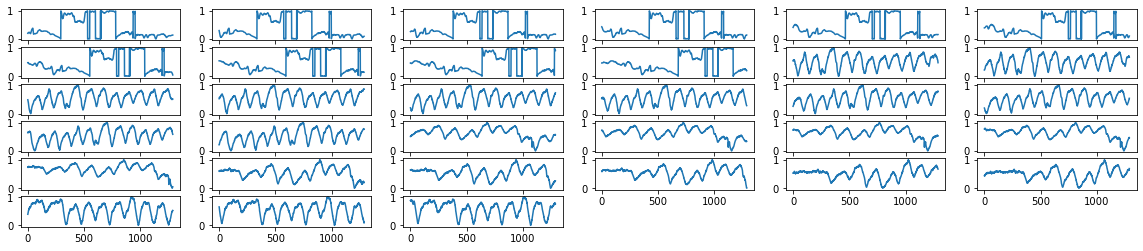

<Figure size 432x288 with 0 Axes>

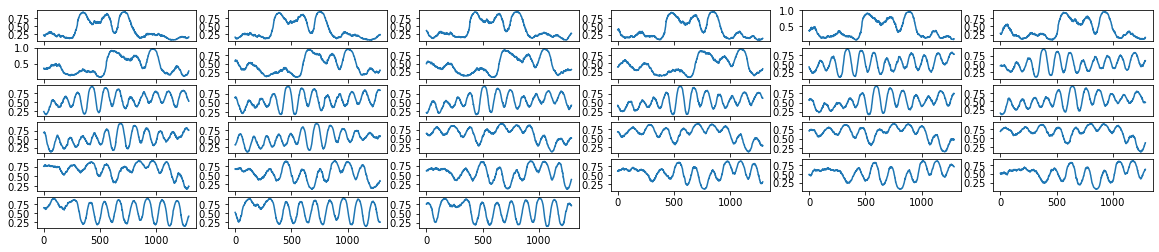

In [17]:
data2 = uc_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Plot signal and its encoded representation:

<Figure size 432x288 with 0 Axes>

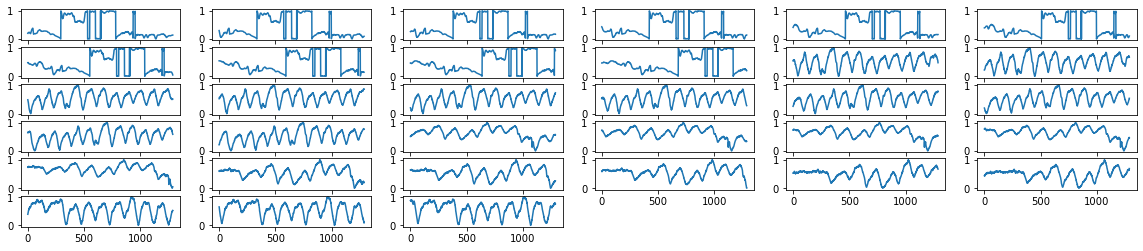

<Figure size 432x288 with 0 Axes>

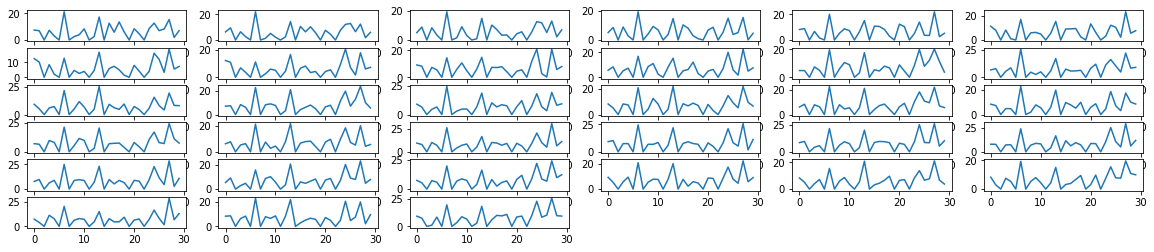

In [18]:
data2 = uc_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Store the encoded representations in the data dictionary:

In [19]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    uc_data = uc_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['undercomplete_encoded'] = uc_data

#### Sparse Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [20]:
def sparse_ae(x, encoding_dim=64, encoded_as_model=False):
    # Simplest possible autoencoder from https://blog.keras.io/building-autoencoders-in-keras.html

    # this is our input placeholder
    input_data = Input(shape=x[0].shape, name="input")
    dropout = Dropout(0.125, name="dropout", seed=42) (input_data)
    # "encoded" is the encoded representation of the input
    # add a sparsity constraint
    encoded = Dense(encoding_dim, activation='relu', name="encoded",
                    activity_regularizer=regularizers.l1(10e-5))(dropout)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(x[0].shape[0], activation='sigmoid', name="decoded")(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_data, decoded, name="sparse_ae")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [21]:
clear_session_and_set_seeds()
sp_ae, sp_enc = sparse_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
sp_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

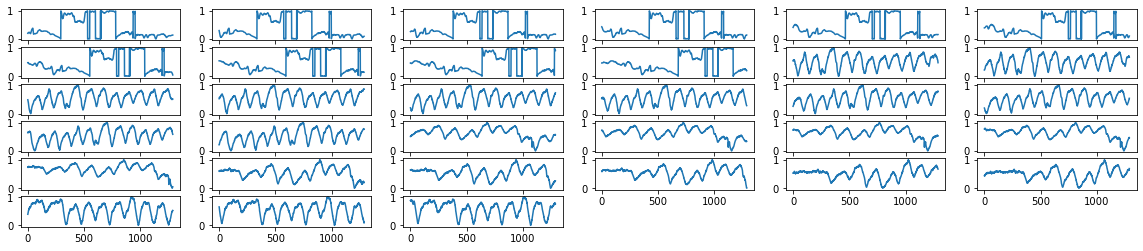

<Figure size 432x288 with 0 Axes>

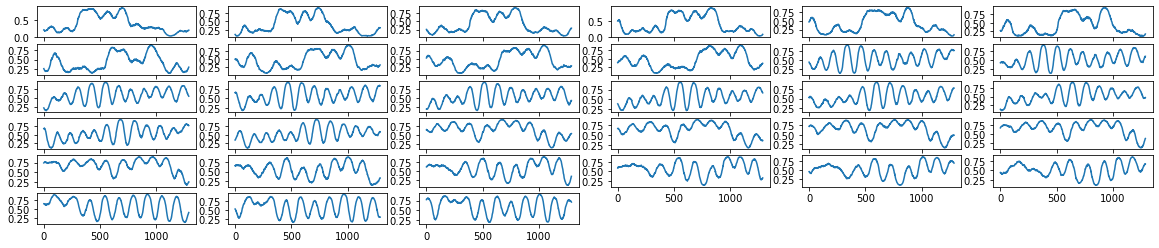

In [22]:
data2 = sp_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Plot signal and its encoded representation:

<Figure size 432x288 with 0 Axes>

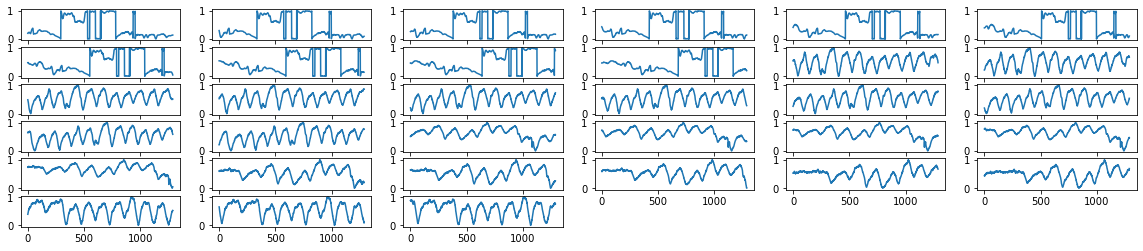

<Figure size 432x288 with 0 Axes>

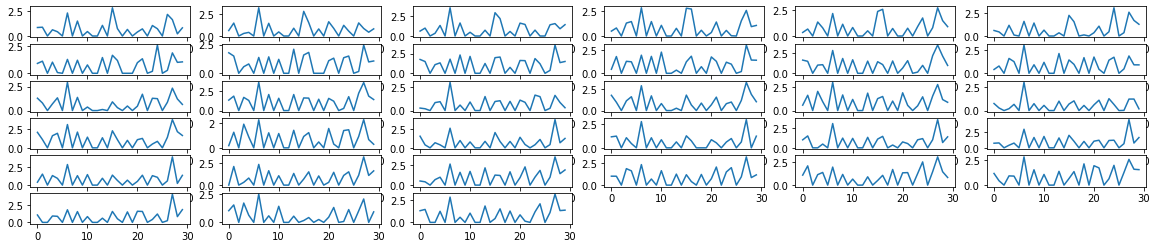

In [23]:
data2 = sp_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Store the encoded representations in the data dictionary:

In [24]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    sp_data = sp_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['sparse_encoded'] = sp_data

#### Deep Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [25]:
def deep_ae(x, enc_layers=[512,128], encoding_dim=64, dec_layers=[128,512], encoded_as_model=False):
    # From https://www.tensorflow.org/guide/keras/functional#use_the_same_graph_of_layers_to_define_multiple_models
    input_data = keras.Input(shape=x[0].shape, name="normalized_signal")
    model = Dropout(0.125, name="dropout", autocast=False, seed=42)(input_data)
    for i in enumerate(enc_layers):
        model = Dense(i[1], activation="relu", name="dense_enc_" + str(i[0]+1))(model)
    encoded_output = Dense(encoding_dim, activation="relu", name="encoded_signal")(model)

    encoded = encoded_output

    model = layers.Dense(dec_layers[0], activation="sigmoid", name="dense_dec_1")(encoded_output)
    for i in enumerate(dec_layers[1:]):
        model = Dense(i[1], activation="sigmoid", name="dense_dec_" + str(i[0]+2))(model)
    decoded_output = Dense(x[0].shape[0], activation="sigmoid", name="reconstructed_signal")(model)
    
    autoencoder = Model(input_data, decoded_output, name="autoencoder")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)

    return autoencoder, encoded

Train autoencoder on data:

In [26]:
clear_session_and_set_seeds()
de_ae, de_enc = deep_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
de_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

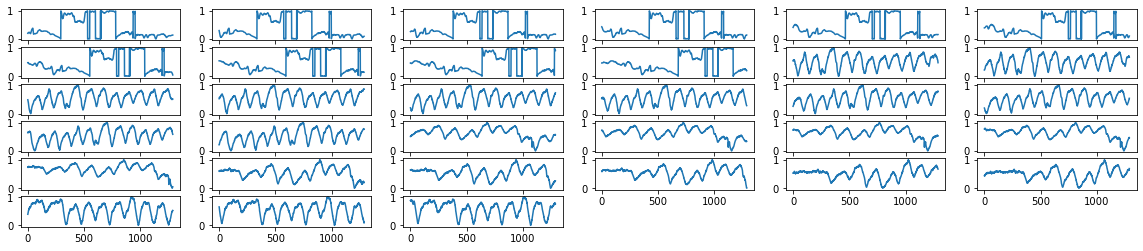

<Figure size 432x288 with 0 Axes>

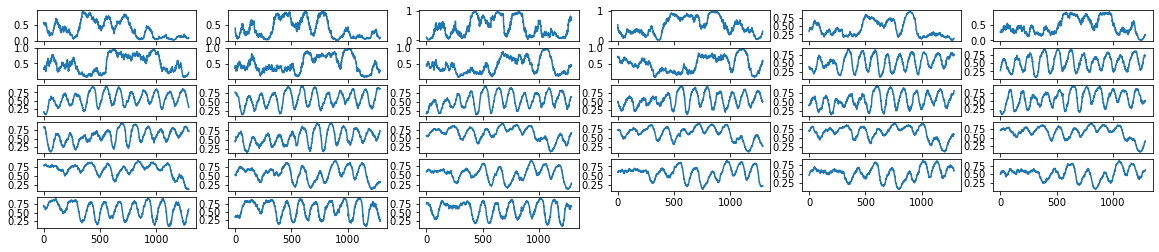

In [27]:
data2 = de_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Plot signal and its encoded representation:

<Figure size 432x288 with 0 Axes>

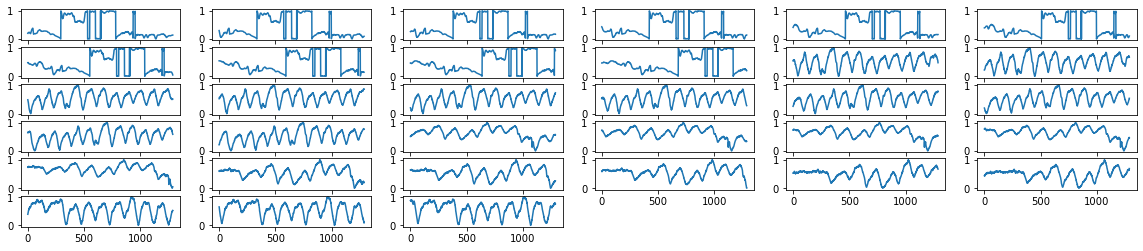

<Figure size 432x288 with 0 Axes>

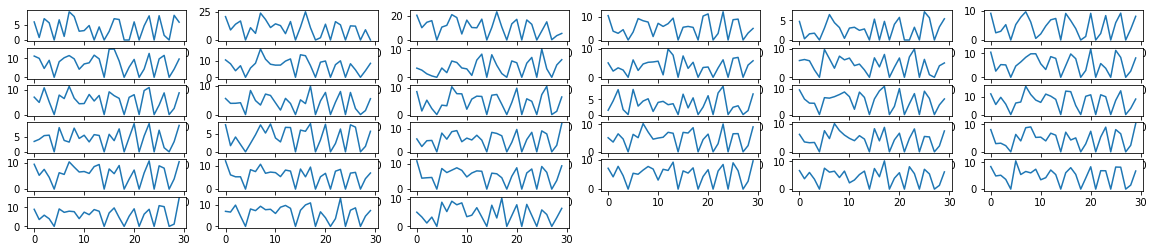

In [28]:
data2 = de_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Store the encoded representations in the data dictionary:

In [29]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    de_data = de_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['deep_encoded'] = de_data

Helper function to get data from the dictionary:

In [30]:
def get_ident_data_from_dict(idents, data_dict):
    
    # Initialize data variables
    y = y_shape.copy()
    phase = phase_shape.copy()
    breathing = breathing_shape.copy()
    heartbeat = heartbeat_shape.copy()
    combined = combined_shape.copy()
    undercomplete_encoded = ae_encoded_shape.copy()
    sparse_encoded = ae_encoded_shape.copy()
    deep_encoded = ae_encoded_shape.copy()
    
    # Stack data form each ident into the variables
    for tmp_id in idents:
        y = np.vstack((y, data_dict[tmp_id]['y']))
        phase = np.vstack((phase, data_dict[tmp_id]['phase']))
        breathing = np.vstack((breathing, data_dict[tmp_id]['breathing']))
        heartbeat = np.vstack((heartbeat, data_dict[tmp_id]['heartbeat']))
        combined = np.vstack((combined, data_dict[tmp_id]['combined']))
        undercomplete_encoded = np.vstack((undercomplete_encoded, data_dict[tmp_id]['undercomplete_encoded']))
        sparse_encoded = np.vstack((sparse_encoded, data_dict[tmp_id]['sparse_encoded']))
        deep_encoded = np.vstack((deep_encoded, data_dict[tmp_id]['deep_encoded']))
    
    return y, phase, breathing, heartbeat, combined, undercomplete_encoded, sparse_encoded, deep_encoded

## Classifiers

#### Helper loop function definition  
A function that loops over all the data and calls the classifiers with it then stores the returned accuracies.

In [31]:
def helper_loop(classifier_function_train, idents, n=5, num_loops_to_average_over=1, should_scale_data=True):
    #returns a dictionary with accuracies

    # set the variables in the dictionary
    accs = {}
    accs['phase'] = []
    accs['breathing'] = []
    accs['heartbeat'] = []
    accs['combined br hb'] = []
    accs['undercomplete'] = []
    accs['sparse'] = []
    accs['deep'] = []
    accs['test id'] = []
    start_time = datetime.now()

    # leave out person out validation
    for i in range(n):
        
        # print current iteration and time elapsed from start
        print("iteration:", i+1, "of", n, "; time elapsed:", datetime.now()-start_time)

        ## ----- Data preparation:
        validation_idents = [idents[i]]
        test_idents = [idents[i-1]]
        
        train_idents = []
        for ident in idents:
            if (ident not in test_idents) and (ident not in validation_idents):
                train_idents.append(ident)

        # save test id to see which id yielded which accuracies
        accs['test id'].append(test_idents[0])

        # Load train data
        train_data = get_ident_data_from_dict(train_idents, data_dict)
        y_train = train_data[0]
        
        # Load validation data
        valid_data = get_ident_data_from_dict(validation_idents, data_dict)
        y_valid = valid_data[0]

        # Load test data
        test_data = get_ident_data_from_dict(test_idents, data_dict)
        y_test = test_data[0]
        
        data_names_by_index = ['y', 'phase', 'breathing', 'heartbeat',
                                   'combined br hb', 'undercomplete', 'sparse', 'deep']

        # Loop over all data that will be used for classification and send it to the classifier
        # index 0 is y so we skip it
        for index in range(1, len(test_data)):
            clear_session_and_set_seeds()
            train_x = train_data[index]
            valid_x = valid_data[index]
            test_x = test_data[index]
            
            # Scale data
            if should_scale_data:
                
                # scale phase in a different way than other features
                if (index == 1): 
                    # Scale each row with standard scaler
                    train_x = scale(train_x, axis=1)
                    valid_x = scale(valid_x, axis=1)
                    test_x = scale(test_x, axis=1)
                    # Scale each row with MinMax to range [0,1]
                    train_x = MinMaxScaler().fit_transform(train_x.T).T
                    valid_x = MinMaxScaler().fit_transform(valid_x.T).T
                    test_x = MinMaxScaler().fit_transform(test_x.T).T
                else:
                    # Scale with standard scaler
                    sscaler = StandardScaler()
                    sscaler.fit(train_x)
                    train_x = sscaler.transform(train_x)

                    # Scale with MinMax to range [0,1]
                    mmscaler = MinMaxScaler((0,1))
                    mmscaler.fit(train_x)
                    train_x = mmscaler.transform(train_x)

                    # Scale valid and test with train's scalers
                    valid_x = sscaler.transform(valid_x)
                    valid_x = mmscaler.transform(valid_x)
                    
                    test_x = sscaler.transform(test_x)
                    test_x = mmscaler.transform(test_x)
            
            # Initialize variables
            tmp_acc = []
            data_name = data_names_by_index[index]
            
            for tmp_index in range(num_loops_to_average_over):
                curr_acc = classifier_function_train(train_x, y_train, valid_x, y_valid, test_x, y_test, data_name)
                tmp_acc.append(curr_acc)
            
            # Store accuracy
            curr_acc = np.mean(tmp_acc)
            accs[data_name].append(curr_acc)
        

    # Print total time required to run this
    end_time = datetime.now()
    elapsed_time = end_time - start_time
    print("Completed!", "Time elapsed:", elapsed_time)
    
    return accs

#### Simple dense classifier

Define the classifier:

In [32]:
params = {
    'dropout': 0.24,
    'optimizer': 'Adam',
    'hidden_size': 64,
    'loss': 'binary_crossentropy',
    'last_activation': 'sigmoid',
    'activation': 'softmax',
    'batch_size': 256,
    'epochs': 100
}

In [33]:
def dense_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    
    # Define the model
    model = Sequential()
    model.add(Dropout(0))
    model.add(Dense(32))
    model.add(Activation('sigmoid'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=metrics)
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, x_train, y_train, params['batch_size'], params['epochs'],
                                           x_valid, y_valid, x_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [34]:
accs = helper_loop(dense_train, idents, n, num_loops_to_average_over=3)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:57.741930
iteration: 3 of 23 ; time elapsed: 0:01:55.658248
iteration: 4 of 23 ; time elapsed: 0:02:53.673289
iteration: 5 of 23 ; time elapsed: 0:03:51.711967
iteration: 6 of 23 ; time elapsed: 0:04:49.597388
iteration: 7 of 23 ; time elapsed: 0:05:47.669018
iteration: 8 of 23 ; time elapsed: 0:06:48.335028
iteration: 9 of 23 ; time elapsed: 0:07:53.274212
iteration: 10 of 23 ; time elapsed: 0:08:55.956526
iteration: 11 of 23 ; time elapsed: 0:09:57.507925
iteration: 12 of 23 ; time elapsed: 0:10:57.576442
iteration: 13 of 23 ; time elapsed: 0:11:57.443287
iteration: 14 of 23 ; time elapsed: 0:12:57.282250
iteration: 15 of 23 ; time elapsed: 0:13:56.127494
iteration: 16 of 23 ; time elapsed: 0:14:54.293028
iteration: 17 of 23 ; time elapsed: 0:15:52.118987
iteration: 18 of 23 ; time elapsed: 0:16:50.119630
iteration: 19 of 23 ; time elapsed: 0:17:47.912431
iteration: 20 of 23 ; time elapsed: 0:18:46.347

In [35]:
accuracies['simple_dense'] = accs

In [36]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.466667,0.625000,0.444444,0.536111,0.533333,0.452778,0.452778,62i9y
1,0.547222,0.644444,0.544444,0.552778,0.488889,0.541667,0.530556,2gu87
2,0.475000,0.297222,0.586111,0.308333,0.500000,0.463889,0.505556,iz2ps
3,0.552778,0.405556,0.500000,0.422222,0.491667,0.411111,0.425000,1mpau
4,0.447222,0.388889,0.338889,0.372222,0.466667,0.444444,0.444444,7dwjy
5,0.480556,0.413889,0.558333,0.377778,0.383333,0.488889,0.416667,7swyk
6,0.788889,0.538889,0.633333,0.566667,0.530556,0.677778,0.577778,94mnx
7,0.561111,0.569444,0.463889,0.505556,0.450000,0.419444,0.561111,bd47a
8,0.519444,0.488889,0.572222,0.472222,0.580556,0.500000,0.583333,c24ur
9,0.555556,0.255556,0.497222,0.447222,0.513889,0.413889,0.580556,ctsax


In [37]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.311111   0.255556   0.336111        0.308333       0.291667  0.350000  0.350000
max     0.788889   0.713889   0.663889        0.611111       0.594444  0.677778  0.619444
mean    0.473792   0.493116   0.511473        0.502536       0.487077  0.494565  0.503502
median  0.477778   0.494444   0.511111        0.533333       0.491667  0.500000  0.511111


#### LSTM-based classifier  
based on the original author's code

In [38]:
params_phase = {
    'kernel_size': 4,
    'filters': 64,
    'strides': 4,
    'pool_size': 4,
    'dropout': 0.09,
    'lstm_output_size': 256,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': 'Nadam',
    'batch_size': 128,
    'epochs': 100
}

In [39]:
params_br_hb = {
    'kernel_size': 2,
    'filters': 6,
    'strides': 2,
    'pool_size': 2,
    'dropout': 0.09,
    'lstm_output_size': 8,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': 'Nadam',
    'batch_size': 64,
    'epochs': 100
}

In [40]:
def LSTM_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    # change parameters based on which data this gets
    # because phase data has more values so some parameters can be larger (e.g. kernel)
    params = params_br_hb
    if (data_name == 'phase'):
        params = params_phase
    
    # Reshape data to fit some layers
    xt_train = x_train.reshape(-1, x_train[0].shape[0], 1)
    xt_valid = x_valid.reshape(-1, x_valid[0].shape[0], 1)
    xt_test = x_test.reshape(-1, x_test[0].shape[0], 1)
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Conv1D(params['filters'],
                     params['kernel_size'],
                     padding='valid',
                     activation=params['activation'],
                     strides=params['strides']))

    model.add(MaxPooling1D(pool_size=params['pool_size']))
    
    if (data_name == 'phase'):
        model.add(Conv1D(params['filters'],
                         params['kernel_size'],
                         padding='valid',
                         activation=params['activation'],
                         strides=params['strides']))
        model.add(MaxPooling1D(pool_size=params['pool_size']))

    model.add(Dropout(params['dropout']))
    model.add(LSTM(params['lstm_output_size']))
    model.add(Dense(1))
    model.add(Activation(params['last_activation']))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'],
                  metrics=['acc'])
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, xt_train, y_train, params['batch_size'], params['epochs'],
                                           xt_valid, y_valid, xt_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [41]:
accs = helper_loop(LSTM_train, idents, n=n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:02:24.271050
iteration: 3 of 23 ; time elapsed: 0:04:49.663103
iteration: 4 of 23 ; time elapsed: 0:07:14.298182
iteration: 5 of 23 ; time elapsed: 0:09:38.606134
iteration: 6 of 23 ; time elapsed: 0:12:02.272802
iteration: 7 of 23 ; time elapsed: 0:14:26.223711
iteration: 8 of 23 ; time elapsed: 0:17:03.420462
iteration: 9 of 23 ; time elapsed: 0:19:32.545980
iteration: 10 of 23 ; time elapsed: 0:22:02.842266
iteration: 11 of 23 ; time elapsed: 0:24:29.929061
iteration: 12 of 23 ; time elapsed: 0:27:00.417730
iteration: 13 of 23 ; time elapsed: 0:29:28.128568
iteration: 14 of 23 ; time elapsed: 0:31:52.109153
iteration: 15 of 23 ; time elapsed: 0:34:16.218907
iteration: 16 of 23 ; time elapsed: 0:36:41.963780
iteration: 17 of 23 ; time elapsed: 0:39:04.022942
iteration: 18 of 23 ; time elapsed: 0:41:24.984111
iteration: 19 of 23 ; time elapsed: 0:43:46.848817
iteration: 20 of 23 ; time elapsed: 0:46:04.798

In [42]:
accuracies['LSTM'] = accs

In [43]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.608333,0.483333,0.575000,0.575000,0.425000,0.358333,0.416667,62i9y
1,0.450000,0.475000,0.525000,0.475000,0.441667,0.475000,0.550000,2gu87
2,0.366667,0.308333,0.583333,0.216667,0.350000,0.425000,0.391667,iz2ps
3,0.566667,0.566667,0.325000,0.550000,0.425000,0.516667,0.508333,1mpau
4,0.575000,0.391667,0.408333,0.483333,0.500000,0.583333,0.441667,7dwjy
5,0.558333,0.491667,0.525000,0.491667,0.750000,0.575000,0.608333,7swyk
6,0.583333,0.425000,0.416667,0.316667,0.625000,0.508333,0.683333,94mnx
7,0.600000,0.516667,0.583333,0.600000,0.666667,0.600000,0.575000,bd47a
8,0.491667,0.483333,0.466667,0.425000,0.500000,0.458333,0.583333,c24ur
9,0.466667,0.400000,0.558333,0.350000,0.583333,0.558333,0.583333,ctsax


In [44]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.366667   0.258333   0.325000        0.216667       0.350000  0.358333  0.341667
max     0.616667   0.700000   0.625000        0.775000       0.750000  0.775000  0.683333
mean    0.506159   0.454348   0.504710        0.475000       0.517754  0.534058  0.519928
median  0.491667   0.458333   0.508333        0.491667       0.500000  0.541667  0.541667


#### kNN

In [45]:
from sklearn.neighbors import KNeighborsClassifier

def KNN_classifier():
    model = KNeighborsClassifier(p=3, n_neighbors=7, metric='cosine')
    return model

In [46]:
def KNN_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = KNN_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [47]:
accs = helper_loop(KNN_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:00.383512
iteration: 3 of 23 ; time elapsed: 0:00:00.721090
iteration: 4 of 23 ; time elapsed: 0:00:01.057998
iteration: 5 of 23 ; time elapsed: 0:00:01.390203
iteration: 6 of 23 ; time elapsed: 0:00:01.736247
iteration: 7 of 23 ; time elapsed: 0:00:02.087341
iteration: 8 of 23 ; time elapsed: 0:00:02.422455
iteration: 9 of 23 ; time elapsed: 0:00:02.754004
iteration: 10 of 23 ; time elapsed: 0:00:03.092342
iteration: 11 of 23 ; time elapsed: 0:00:03.420013
iteration: 12 of 23 ; time elapsed: 0:00:03.753125
iteration: 13 of 23 ; time elapsed: 0:00:04.122169
iteration: 14 of 23 ; time elapsed: 0:00:04.485944
iteration: 15 of 23 ; time elapsed: 0:00:04.824855
iteration: 16 of 23 ; time elapsed: 0:00:05.175921
iteration: 17 of 23 ; time elapsed: 0:00:05.517968
iteration: 18 of 23 ; time elapsed: 0:00:05.855098
iteration: 19 of 23 ; time elapsed: 0:00:06.194576
iteration: 20 of 23 ; time elapsed: 0:00:06.544

In [48]:
accuracies['kNN'] = accs

In [49]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.416667,0.558333,0.441667,0.450000,0.458333,0.566667,0.483333,62i9y
1,0.341667,0.458333,0.441667,0.500000,0.416667,0.516667,0.483333,2gu87
2,0.433333,0.525000,0.466667,0.550000,0.600000,0.450000,0.675000,iz2ps
3,0.591667,0.508333,0.583333,0.500000,0.458333,0.550000,0.641667,1mpau
4,0.441667,0.575000,0.425000,0.500000,0.408333,0.441667,0.408333,7dwjy
5,0.591667,0.583333,0.341667,0.416667,0.516667,0.600000,0.541667,7swyk
6,0.516667,0.600000,0.400000,0.691667,0.558333,0.608333,0.691667,94mnx
7,0.591667,0.416667,0.658333,0.350000,0.508333,0.516667,0.441667,bd47a
8,0.491667,0.341667,0.466667,0.650000,0.575000,0.466667,0.491667,c24ur
9,0.483333,0.383333,0.566667,0.441667,0.391667,0.408333,0.383333,ctsax


In [50]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.341667   0.341667   0.341667        0.350000       0.391667  0.400000  0.383333
max     0.675000   0.600000   0.658333        0.700000       0.600000  0.608333  0.691667
mean    0.487681   0.494928   0.496739        0.501087       0.499275  0.528623  0.531159
median  0.483333   0.508333   0.483333        0.500000       0.508333  0.541667  0.508333


####  SVC

In [51]:
from sklearn.svm import SVC

def SVC_classifier():
    model = SVC(kernel='rbf', C=1.5)
    return model

In [52]:
def SVC_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = SVC_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [53]:
accs = helper_loop(SVC_train, idents, n, num_loops_to_average_over=5)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:51.160712
iteration: 3 of 23 ; time elapsed: 0:01:42.546603
iteration: 4 of 23 ; time elapsed: 0:02:34.619626
iteration: 5 of 23 ; time elapsed: 0:03:26.403631
iteration: 6 of 23 ; time elapsed: 0:04:18.161194
iteration: 7 of 23 ; time elapsed: 0:05:10.457207
iteration: 8 of 23 ; time elapsed: 0:06:02.782381
iteration: 9 of 23 ; time elapsed: 0:06:54.900219
iteration: 10 of 23 ; time elapsed: 0:07:46.717325
iteration: 11 of 23 ; time elapsed: 0:08:38.135647
iteration: 12 of 23 ; time elapsed: 0:09:29.584536
iteration: 13 of 23 ; time elapsed: 0:10:21.220555
iteration: 14 of 23 ; time elapsed: 0:11:12.731914
iteration: 15 of 23 ; time elapsed: 0:12:04.246404
iteration: 16 of 23 ; time elapsed: 0:12:55.351581
iteration: 17 of 23 ; time elapsed: 0:13:46.651726
iteration: 18 of 23 ; time elapsed: 0:14:37.828149
iteration: 19 of 23 ; time elapsed: 0:15:29.156012
iteration: 20 of 23 ; time elapsed: 0:16:20.231

In [54]:
accuracies['SVC'] = accs

In [55]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.275000,0.625000,0.533333,0.666667,0.400000,0.466667,0.516667,62i9y
1,0.475000,0.400000,0.600000,0.500000,0.366667,0.458333,0.566667,2gu87
2,0.441667,0.375000,0.383333,0.250000,0.366667,0.466667,0.375000,iz2ps
3,0.591667,0.508333,0.483333,0.483333,0.575000,0.633333,0.550000,1mpau
4,0.433333,0.550000,0.533333,0.491667,0.550000,0.508333,0.450000,7dwjy
5,0.508333,0.366667,0.525000,0.391667,0.558333,0.533333,0.500000,7swyk
6,0.725000,0.591667,0.466667,0.550000,0.558333,0.550000,0.583333,94mnx
7,0.558333,0.641667,0.575000,0.541667,0.500000,0.525000,0.616667,bd47a
8,0.483333,0.483333,0.516667,0.541667,0.350000,0.416667,0.583333,c24ur
9,0.516667,0.491667,0.433333,0.441667,0.508333,0.408333,0.633333,ctsax


In [56]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.250000   0.366667   0.366667        0.250000       0.350000  0.341667  0.375000
max     0.725000   0.641667   0.666667        0.666667       0.658333  0.675000  0.641667
mean    0.466304   0.513043   0.505072        0.492391       0.500725  0.536232  0.532971
median  0.475000   0.516667   0.516667        0.491667       0.508333  0.525000  0.566667


#### Random Forest

In [57]:
from sklearn.ensemble import RandomForestClassifier
def random_forest_classifier():
    model = RandomForestClassifier(n_estimators = 250,
                                     min_samples_split = 10,
                                     min_samples_leaf = 4,
                                     max_features = 'auto',
                                     max_depth = 90,
                                     bootstrap = True)
    return model

In [58]:
def random_forest_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = random_forest_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [59]:
accs = helper_loop(random_forest_train, idents, n, should_scale_data=False, num_loops_to_average_over=5)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:01:28.526459
iteration: 3 of 23 ; time elapsed: 0:02:56.763772
iteration: 4 of 23 ; time elapsed: 0:04:24.176710
iteration: 5 of 23 ; time elapsed: 0:05:52.169521
iteration: 6 of 23 ; time elapsed: 0:07:16.080035
iteration: 7 of 23 ; time elapsed: 0:08:43.065638
iteration: 8 of 23 ; time elapsed: 0:10:18.050562
iteration: 9 of 23 ; time elapsed: 0:11:50.587528
iteration: 10 of 23 ; time elapsed: 0:13:19.590422
iteration: 11 of 23 ; time elapsed: 0:14:50.340642
iteration: 12 of 23 ; time elapsed: 0:16:20.242228
iteration: 13 of 23 ; time elapsed: 0:17:52.990603
iteration: 14 of 23 ; time elapsed: 0:19:26.490503
iteration: 15 of 23 ; time elapsed: 0:20:51.779102
iteration: 16 of 23 ; time elapsed: 0:22:20.000411
iteration: 17 of 23 ; time elapsed: 0:23:47.951138
iteration: 18 of 23 ; time elapsed: 0:25:16.630886
iteration: 19 of 23 ; time elapsed: 0:26:44.149380
iteration: 20 of 23 ; time elapsed: 0:28:12.937

In [60]:
accuracies['random_forest'] = accs

In [61]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.390000,0.491667,0.558333,0.491667,0.426667,0.441667,0.408333,62i9y
1,0.401667,0.553333,0.420000,0.623333,0.386667,0.421667,0.440000,2gu87
2,0.401667,0.465000,0.303333,0.450000,0.483333,0.398333,0.391667,iz2ps
3,0.605000,0.541667,0.540000,0.458333,0.370000,0.490000,0.425000,1mpau
4,0.338333,0.491667,0.511667,0.555000,0.505000,0.470000,0.471667,7dwjy
5,0.368333,0.471667,0.451667,0.460000,0.368333,0.340000,0.380000,7swyk
6,0.521667,0.691667,0.490000,0.615000,0.413333,0.458333,0.460000,94mnx
7,0.488333,0.521667,0.718333,0.386667,0.410000,0.495000,0.490000,bd47a
8,0.391667,0.420000,0.558333,0.433333,0.363333,0.373333,0.403333,c24ur
9,0.450000,0.408333,0.498333,0.346667,0.460000,0.413333,0.466667,ctsax


In [62]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.285000   0.408333   0.303333        0.346667       0.321667  0.340000  0.363333
max     0.621667   0.691667   0.718333        0.708333       0.635000  0.663333  0.678333
mean    0.469783   0.513986   0.501522        0.516377       0.455580  0.487536  0.464710
median  0.475000   0.491667   0.498333        0.491667       0.456667  0.490000  0.440000


#### Naive Bayesian

In [63]:
from sklearn.naive_bayes import ComplementNB

def naive_bayesian_classifier():
    model = ComplementNB()
    return model

In [64]:
def naive_bayesian_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = naive_bayesian_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [65]:
accs = helper_loop(naive_bayesian_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:00.256674
iteration: 3 of 23 ; time elapsed: 0:00:00.502019
iteration: 4 of 23 ; time elapsed: 0:00:00.802187
iteration: 5 of 23 ; time elapsed: 0:00:01.048102
iteration: 6 of 23 ; time elapsed: 0:00:01.295040
iteration: 7 of 23 ; time elapsed: 0:00:01.548363
iteration: 8 of 23 ; time elapsed: 0:00:01.799337
iteration: 9 of 23 ; time elapsed: 0:00:02.056642
iteration: 10 of 23 ; time elapsed: 0:00:02.303331
iteration: 11 of 23 ; time elapsed: 0:00:02.553151
iteration: 12 of 23 ; time elapsed: 0:00:02.813513
iteration: 13 of 23 ; time elapsed: 0:00:03.070192
iteration: 14 of 23 ; time elapsed: 0:00:03.309552
iteration: 15 of 23 ; time elapsed: 0:00:03.555265
iteration: 16 of 23 ; time elapsed: 0:00:03.807623
iteration: 17 of 23 ; time elapsed: 0:00:04.049647
iteration: 18 of 23 ; time elapsed: 0:00:04.335881
iteration: 19 of 23 ; time elapsed: 0:00:04.576809
iteration: 20 of 23 ; time elapsed: 0:00:04.836

In [66]:
accuracies['naive_bayesian'] = accs

In [67]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.416667,0.508333,0.441667,0.500000,0.500000,0.508333,0.366667,62i9y
1,0.658333,0.591667,0.508333,0.558333,0.500000,0.500000,0.583333,2gu87
2,0.591667,0.350000,0.483333,0.341667,0.550000,0.616667,0.516667,iz2ps
3,0.600000,0.341667,0.516667,0.333333,0.333333,0.325000,0.483333,1mpau
4,0.558333,0.425000,0.341667,0.425000,0.500000,0.483333,0.500000,7dwjy
5,0.591667,0.275000,0.633333,0.316667,0.433333,0.416667,0.508333,7swyk
6,0.850000,0.475000,0.583333,0.491667,0.500000,0.550000,0.775000,94mnx
7,0.441667,0.558333,0.416667,0.625000,0.433333,0.383333,0.466667,bd47a
8,0.525000,0.500000,0.633333,0.491667,0.500000,0.558333,0.466667,c24ur
9,0.500000,0.241667,0.500000,0.266667,0.416667,0.408333,0.441667,ctsax


In [68]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.316667   0.241667   0.291667        0.266667       0.308333  0.300000  0.366667
max     0.850000   0.708333   0.633333        0.716667       0.733333  0.675000  0.775000
mean    0.535507   0.480435   0.480072        0.485507       0.487319  0.489493  0.513406
median  0.533333   0.500000   0.483333        0.491667       0.500000  0.500000  0.508333


#### XGBoost

In [69]:
from xgboost import XGBClassifier

def XGBoost_classifier():
    model = XGBClassifier(n_estimators = 83)
    return model

In [70]:
def XGBoost_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = XGBoost_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [71]:
accs = helper_loop(XGBoost_train, idents, n, should_scale_data=False, num_loops_to_average_over=5)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:46.773465
iteration: 3 of 23 ; time elapsed: 0:01:29.903426
iteration: 4 of 23 ; time elapsed: 0:02:11.987021
iteration: 5 of 23 ; time elapsed: 0:02:53.524257
iteration: 6 of 23 ; time elapsed: 0:03:35.702227
iteration: 7 of 23 ; time elapsed: 0:04:17.828961
iteration: 8 of 23 ; time elapsed: 0:04:59.641292
iteration: 9 of 23 ; time elapsed: 0:05:41.140155
iteration: 10 of 23 ; time elapsed: 0:06:22.627818
iteration: 11 of 23 ; time elapsed: 0:07:04.029758
iteration: 12 of 23 ; time elapsed: 0:07:45.181693
iteration: 13 of 23 ; time elapsed: 0:08:26.928810
iteration: 14 of 23 ; time elapsed: 0:09:08.893319
iteration: 15 of 23 ; time elapsed: 0:09:54.491790
iteration: 16 of 23 ; time elapsed: 0:10:36.796040
iteration: 17 of 23 ; time elapsed: 0:11:18.514755
iteration: 18 of 23 ; time elapsed: 0:11:58.778487
iteration: 19 of 23 ; time elapsed: 0:12:41.759774
iteration: 20 of 23 ; time elapsed: 0:13:23.762

In [72]:
accuracies['XGBoost'] = accs

In [73]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.366667,0.583333,0.591667,0.508333,0.441667,0.441667,0.400000,62i9y
1,0.450000,0.491667,0.450000,0.608333,0.416667,0.366667,0.466667,2gu87
2,0.383333,0.450000,0.408333,0.466667,0.458333,0.475000,0.458333,iz2ps
3,0.575000,0.558333,0.483333,0.425000,0.433333,0.566667,0.483333,1mpau
4,0.416667,0.516667,0.558333,0.600000,0.516667,0.566667,0.566667,7dwjy
5,0.408333,0.541667,0.441667,0.516667,0.391667,0.375000,0.408333,7swyk
6,0.541667,0.700000,0.383333,0.625000,0.433333,0.516667,0.533333,94mnx
7,0.508333,0.583333,0.808333,0.466667,0.475000,0.566667,0.583333,bd47a
8,0.391667,0.366667,0.533333,0.450000,0.383333,0.375000,0.400000,c24ur
9,0.516667,0.366667,0.425000,0.441667,0.483333,0.508333,0.533333,ctsax


In [74]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.366667   0.366667   0.341667        0.358333       0.358333  0.366667  0.358333
max     0.583333   0.700000   0.808333        0.766667       0.666667  0.658333  0.633333
mean    0.483696   0.508333   0.504710        0.532609       0.466667  0.489855  0.493478
median  0.483333   0.500000   0.491667        0.508333       0.450000  0.491667  0.508333


###  Compare Accuracies

Print min, max, mean, median for each clasifier/autoencoder combination:

In [75]:
for classifier in accuracies:
    print("-----------", classifier + ":", "-----------")
    accs = accuracies[classifier]
    print_accs_stats(accs)
    print("\n")

----------- simple_dense: -----------
           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.311111   0.255556   0.336111        0.308333       0.291667  0.350000  0.350000
max     0.788889   0.713889   0.663889        0.611111       0.594444  0.677778  0.619444
mean    0.473792   0.493116   0.511473        0.502536       0.487077  0.494565  0.503502
median  0.477778   0.494444   0.511111        0.533333       0.491667  0.500000  0.511111


----------- LSTM: -----------
           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.366667   0.258333   0.325000        0.216667       0.350000  0.358333  0.341667
max     0.616667   0.700000   0.625000        0.775000       0.750000  0.775000  0.683333
mean    0.506159   0.454348   0.504710        0.475000       0.517754  0.534058  0.519928
median  0.491667   0.458333   0.508333        0.491667       0.500000  0.541667  0.541667


----------- kNN: -----------

Print all accuracies in table form:

In [76]:
for classifier in accuracies:
    print(classifier + ":")
#     print(pandas.DataFrame.from_dict(accuracies[classifier]))
    # Using .to_string() gives nicer loooking results (doesn't split into new line)
    print(pandas.DataFrame.from_dict(accuracies[classifier]).to_string())
    print("\n")

simple_dense:
       phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep test id
0   0.466667   0.625000   0.444444        0.536111       0.533333  0.452778  0.452778   62i9y
1   0.547222   0.644444   0.544444        0.552778       0.488889  0.541667  0.530556   2gu87
2   0.475000   0.297222   0.586111        0.308333       0.500000  0.463889  0.505556   iz2ps
3   0.552778   0.405556   0.500000        0.422222       0.491667  0.411111  0.425000   1mpau
4   0.447222   0.388889   0.338889        0.372222       0.466667  0.444444  0.444444   7dwjy
5   0.480556   0.413889   0.558333        0.377778       0.383333  0.488889  0.416667   7swyk
6   0.788889   0.538889   0.633333        0.566667       0.530556  0.677778  0.577778   94mnx
7   0.561111   0.569444   0.463889        0.505556       0.450000  0.419444  0.561111   bd47a
8   0.519444   0.488889   0.572222        0.472222       0.580556  0.500000  0.583333   c24ur
9   0.555556   0.255556   0.497222        0.44